# Assignment 2: Classification for Spatial Data

## Environment setup

In [51]:
## General functions
import os
from pathlib import Path
from datetime import datetime

## Geo/Raster packages
import rasterio
from rasterio import plot as rio_plot

## Calculation functions
import random
import numpy as np
from scipy.signal import convolve2d
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

## Plotting and visualization
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import pandas as pd

# Turn off scientific notation in printing for ease of reading
np.set_printoptions(suppress=True)

In [2]:
### Set global seeds ###
seed = 123
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### ``Question 1``
``Why is it important to set a seed when working on machine learning models?``

Setting a seed is important in order to make the results of machine learning algorithms replicable. This way if we run this line of code multiple times we will always get the same results.

## Data download
### ``Action 1``

``Run the cell below and check if there is a new folder created on colab with the name `rs_data` containing several remote sensing images``

In [3]:
! git clone https://gist.github.com/4369108d21efcba5743675add1c07def.git rs_data

fatal: destination path 'rs_data' already exists and is not an empty directory.


## 1. Data Preparation

In [4]:
def open_raster(raster_path):
    ## Load image and make it readable as a NumPy matrix
    with rasterio.open(raster_path, 'r') as ds:
        return ds.read() 

# images: RGB
img1_rgb = open_raster('rs_data/image1_rgb.tif')
img1_nir = open_raster('rs_data/image1_nir.tif')
img1 = np.concatenate([img1_rgb, img1_nir], axis=0)

## images: NIR
img2_rgb = open_raster('rs_data/image2_rgb.tif')
img2_nir = open_raster('rs_data/image2_nir.tif')
img2 = np.concatenate([img2_rgb, img2_nir], axis=0)

### ground truths ###
## These DO NOT go into the image stack, since we evaluate
## the model predictions against these labelled maps
img1_gt = open_raster('rs_data/image1_groundTruth.tif')
img2_gt = open_raster('rs_data/image2_groundTruth.tif')

c:\Users\lri44\Anaconda3\envs\machine_learning\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [5]:
## These are the ground truth classes with their plot colors.
## Colors are given in # R-G-B-Alpha. Adjust them as you like.
## Note that not all classes are present in our small images
class_colors_dict = {
    'background':     [1,   1,   1,   1], # The background class is ignored during analyses
    'roads':          [0.5, 0.5, 0.5, 1],
    'buildings':      [0,   0,   0,   1],
    'trees':          [0,   0.5, 0,   1],
    'grass':          [0,   1,   0,   1],
    'bare soil':      [0.6, 0.3, 0,   1], # Not present
    'water':          [0,   0,   1,   1],
    'railways':       [1,   1,   0,   1], # Not present
    'swimming pools': [0,   0,   0.6, 1], # Not present
}
class_colors = [v for k,v in class_colors_dict.items()]
class_cm = np.array(class_colors)

## Get ground truth classes found in image 1
gt_values_in_img1 = np.unique(img1_gt)
img1_class_map = class_cm[gt_values_in_img1]
img1_cmap = ListedColormap(img1_class_map)

## Get ground truth classes found in image 2
gt_values_in_img2 = np.unique(img2_gt)
img2_class_map = class_cm[gt_values_in_img2]
img2_cmap = ListedColormap(img2_class_map)

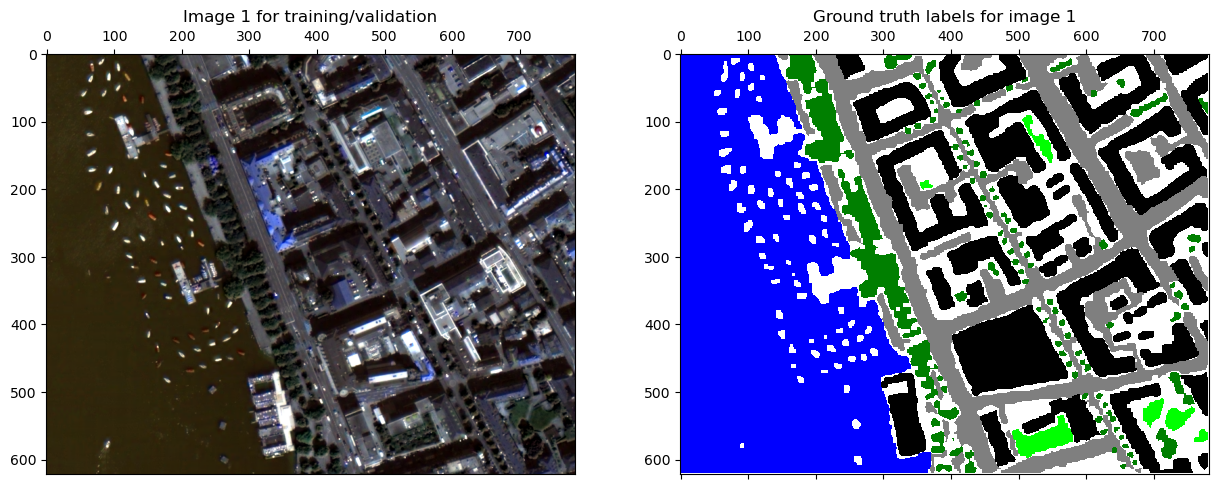

In [6]:
## Plot the first three bands
fig, (ax_img1, ax_img1_gt) = plt.subplots(1, 2, figsize=(15, 15))
rio_plot.show(img1[:3], ax=ax_img1) ## Plot the image on the left
ax_img1.xaxis.set_ticks_position('top')
ax_img1.set_title("Image 1 for training/validation")

ax_img1_gt.matshow(img1_gt[0], cmap=img1_cmap) ## Plot the ground truth image on the right
ax_img1_gt.set_title("Ground truth labels for image 1")
plt.show(fig)

### ``Action 2``

``Define the correct band order on the first line below``

In [7]:
## Fill in the band numbers so that the bands are R-G-B-NIR
corr_band_order = [2,1,0,3]

img1_fixed = np.array([
                       img1[corr_band_order[0]],
                       img1[corr_band_order[1]],
                       img1[corr_band_order[2]],
                       img1[corr_band_order[3]],
                      ])

img2_fixed = np.array([
                       img2[corr_band_order[0]],
                       img2[corr_band_order[1]],
                       img2[corr_band_order[2]],
                       img2[corr_band_order[3]],
                      ])

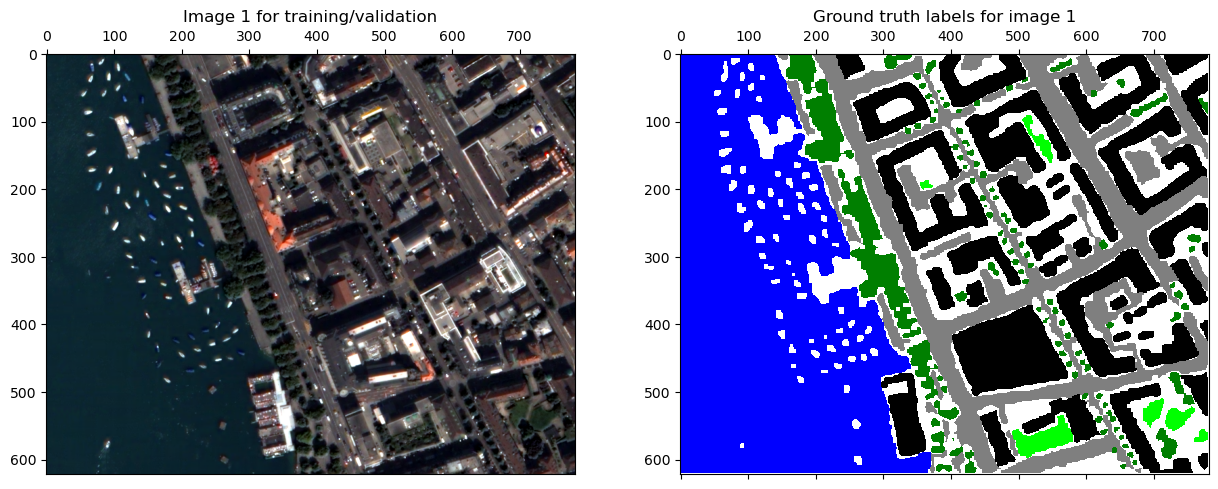

In [8]:
## Plot one of the updated images
fig, (ax_img1_fixed, ax_img1_gt) = plt.subplots(1, 2, figsize=(15,15))
rio_plot.show(img1_fixed[:3], ax=ax_img1_fixed)
ax_img1_fixed.xaxis.set_ticks_position('top')
ax_img1_fixed.set_title("Image 1 for training/validation")

ax_img1_gt.matshow(img1_gt[0], cmap=img1_cmap)
ax_img1_gt.set_title("Ground truth labels for image 1")
plt.show(fig)

## 2. Feature generation

### NDVI
#### ``Action 3``

$$ NDVI = \frac{NIR - Red}{NIR + Red} $$

``Fill in the NDVI formula in the function below``

In [9]:
def calculate_ndvi(red_band, nir_band):
    ## Calculates a new NDVI band from the red and the NIR band
    ndvi = (nir_band - red_band)/(nir_band + red_band)
    return ndvi

In [10]:
## We add a very small constant to the NIR band to prevent division by zero
img1_ndvi = calculate_ndvi(img1_fixed[0], img1_fixed[3]+0.0000001)
img2_ndvi = calculate_ndvi(img2_fixed[0], img2_fixed[3]+0.0000001)

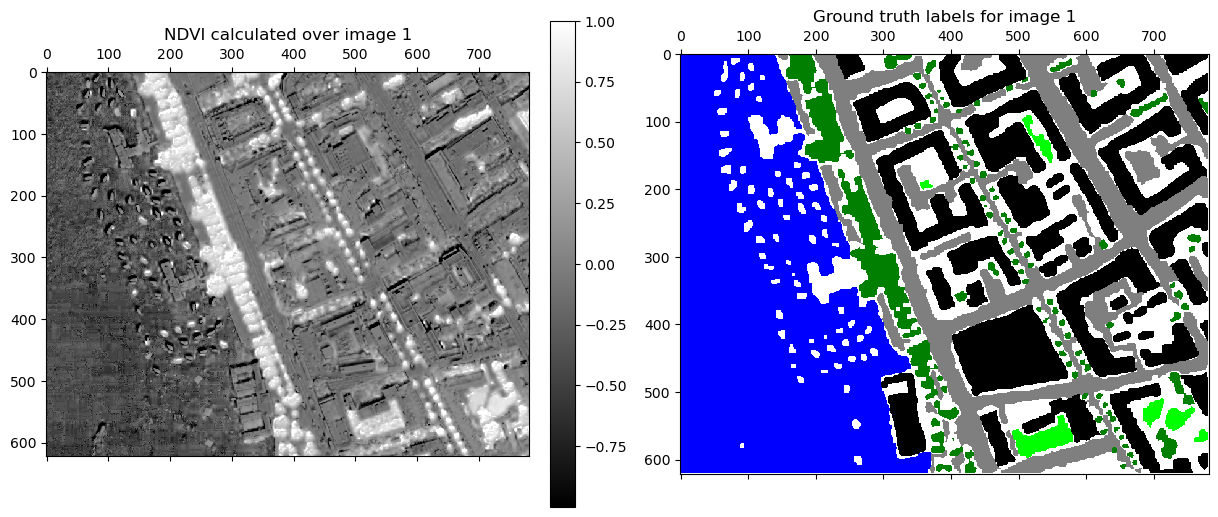

In [11]:
## Plot the calculated NDVI raster
fig, (ax_ndvi, ax_img1_gt) = plt.subplots(1, 2, figsize=(15,15))

im = ax_ndvi.matshow(img1_ndvi, cmap=plt.get_cmap('gist_gray'))
plt.colorbar(im, fraction=0.046, pad=0.04, ax=ax_ndvi)
ax_ndvi.set_title("NDVI calculated over image 1")

ax_img1_gt.matshow(img1_gt[0], cmap=img1_cmap)
ax_img1_gt.set_title("Ground truth labels for image 1")
plt.show(fig)

#### ``Question 2``

``Have a look at the plot above. Are there any classes that are easier to tell apart by the naked eye?``

Yes. Grass and trees are easily spotted in the NDVI image. They have really high values. Moreover, water pixels have really low values.

In [12]:
## Lastly, we merge the NDVI values with the images
## img1_ndvi[:, None] is a Numpy trick to add an extra dimension for concatenation
img1_with_ndvi = np.concatenate([img1_fixed, img1_ndvi[None, :, :]], axis=0)
img2_with_ndvi = np.concatenate([img2_fixed, img2_ndvi[None, :, :]], axis=0)

### Local statistics

In [13]:
## Define the two functions needed to extract local statistics
def calculate_raster_local_means(raster, K):
    ## Function which loops over an entire raster to get local statistics
    ## for each individual band
    raster_local_means = []
    for _, raster_band in enumerate(raster):
        band_local_means = calculate_band_local_mean(raster_band, K)
        band_local_means = band_local_means[None, :]
        raster_local_means.append(band_local_means)
    raster_local_means = np.concatenate(raster_local_means, axis=0)
    
    return raster_local_means

def calculate_band_local_mean(band_matrix, K):
    ## Function that calculates the mean of a raster band within
    ## the square window size K
    ## Adjusted from https://www.delftstack.com/howto/python/moving-average-python/
    N = K ** 2
    padded_band_matrix = np.pad(band_matrix, 1, constant_values = 0)
    local_means = convolve2d(padded_band_matrix, np.ones([K,K]), 'valid') / N
    
    return local_means

In [14]:
## Call the function to extract local statistics
K = 3 # Kernel size for the local statistics sliding window

img1_local_means = calculate_raster_local_means(img1_with_ndvi, K)
img2_local_means = calculate_raster_local_means(img2_with_ndvi, K)

In [15]:
## Load a bunch of extra features to help with the prediction
extra_features_img1 = [str(f) for f in Path('rs_data/').glob('**/im1*')]
img1_extra_features = [open_raster(f) for f in extra_features_img1]
img1_extra_features = np.concatenate(img1_extra_features)

extra_features_img2 = [str(f) for f in Path('rs_data/').glob('**/im2*')]
img2_extra_features = [open_raster(f) for f in extra_features_img2]
img2_extra_features = np.concatenate(img2_extra_features)

In [16]:
## Merge all features
img1_with_features = np.concatenate([img1_with_ndvi, img1_local_means, img1_extra_features], axis=0)
img2_with_features = np.concatenate([img2_with_ndvi, img2_local_means, img2_extra_features], axis=0)

### Normalisation
#### **``Action 4``**

``Fill in the normalization formula for both images. Remember that we need to use the summary statistics of image 1 to normalize image 2!``

In [17]:
def normalize_images(img1, img2):
    ## Function that normalizes the image by whitening it.
    ## We use the summary statistics of image 1 both for
    ## image 1 and 2 so that their distributions allign.
    img1_normalized = []
    img2_normalized = []
    for band_num, img1_band_matrix in enumerate(img1):
        # Calculate the summary statistics for the given band number for image 1
        img1_band_mean = np.mean(img1_band_matrix)
        img1_band_var = np.var(img1_band_matrix)
        img1_std = np.sqrt(img1_band_var)
        
        # Normalize image 1
        ''' FIL IN THE NORMALIZATION FUNCTION FOR THE BAND MATRIX OF IMAGE 1 HERE '''
        normalized_img1_band = (img1_band_matrix - img1_band_mean)/(img1_std)

        # Normalize image 2 using image 1 summary statistics
        img2_band_matrix = img2[band_num]
        ''' FIL IN THE NORMALIZATION FUNCTION FOR THE BAND MATRIX OF IMAGE 2 HERE '''
        normalized_img2_band = (img2_band_matrix - img1_band_mean)/(img1_std)

        # Append bands into a temporary list to later re-create the raster
        normalized_img1_band = normalized_img1_band[None, :]
        img1_normalized.append(normalized_img1_band)
        normalized_img2_band = normalized_img2_band[None, :]
        img2_normalized.append(normalized_img2_band)
    
    img1_normalized = np.concatenate(img1_normalized, )  
    img2_normalized = np.concatenate(img2_normalized)  
    
    return img1_normalized, img2_normalized

In [18]:
img1_normalized, img2_normalized = normalize_images(img1_with_features, img2_with_features)
## If this raises an asseration error, you've not filled in the right variable in the function!
assert len(img1_normalized.shape) == 3

## 3. Data splitting

In [19]:
## Set-up the matrix for training
training_frac = 0.7 # 70% of pixels in img1 for training, 30% for validation
fraction_index = round(training_frac * img1_normalized.shape[1]) # Split along vertical axis

## Make the training/validation splits by splitting the matrix vertically (row-wise)
## The first dimension is the band (feature), the second the row, and the third the column of the image
training_matrix = img1_normalized[:, :fraction_index, :]
training_matrix_labels = img1_gt[:, :fraction_index, :]

validation_matrix = img1_normalized[:, fraction_index:, :]
validation_matrix_labels = img1_gt[0, fraction_index:, :] # The valdidation matrix has only GT labels as band

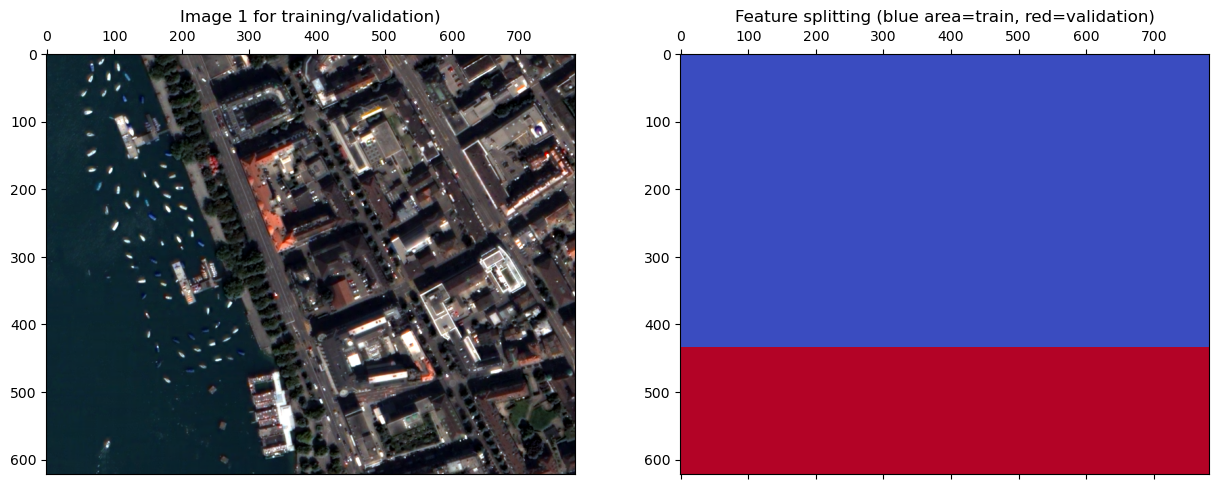

In [20]:
## Make a simple matrix where validation cells are marked with a 1.
## 
splits_fig = np.zeros_like(img1_gt)
## Fill the validation pixels with the value 1.
splits_fig[:, fraction_index:, :] = 1

## Plot the splits used for training
fig, (ax_img1, ax_splits) = plt.subplots(1, 2, figsize=(15, 15))
rio_plot.show(img1_fixed[:3], ax=ax_img1)
ax_img1.set_title("Image 1 for training/validation)")
ax_img1.xaxis.set_ticks_position('top')

ax_splits.matshow(splits_fig[0], cmap=plt.get_cmap('coolwarm'))
ax_splits.set_title("Feature splitting (blue area=train, red=validation)")
plt.show(fig)

#### **``Question 3a``**

``Why do we spatially divide our training and validation data within the same image?``

**``Answer 3a``**

We divide the data spatially to make sure all of the classes are included both in our training and validation set. This is the case for this specific image, because we know that all of the classes are in the upper and the bottom part. However, if we had a different image, probably a different approach would be more suitable.

#### **``Question 3b``**

``What would happen if we pick random pixels instead of spatially stratified pixels?``

**``Answer 3b``**

If we pick random pixels we might encounter some issues, because some LC classes might not be included in either our training or our validation set.

#### **``Question 3c``**

``Why don't we include image 2 during training, and why is it unnecessary to spatially stratify image 2?``

**``Answer 3c``**

We don't include it because this image is meant to test the performance of our classification algorithm. Therefore, the whole image is used to predict the classifications and then measure the accuracy of the model in an unseen dataset.

### Data clean-up

In [21]:
## Flatten the splits so that they're 1-dimensional
train_pixels = training_matrix.reshape(training_matrix.shape[0], training_matrix.shape[1] * training_matrix.shape[2])
train_labels = training_matrix_labels[0].reshape(training_matrix.shape[1] * training_matrix.shape[2])

val_pixels = validation_matrix.reshape(validation_matrix.shape[0], validation_matrix.shape[1] * validation_matrix.shape[2])
val_labels = validation_matrix_labels.reshape(validation_matrix_labels.shape[0] * validation_matrix_labels.shape[1])

## Rearrange the training array so that the dimension axis is last
train_pixels = train_pixels.transpose()
val_pixels = val_pixels.transpose()

## Remove background pixels from the arrays
train_pixels = train_pixels[train_labels != 0, :]
train_labels = train_labels[train_labels != 0]
val_pixels = val_pixels[val_labels != 0, :]
val_labels = val_labels[val_labels != 0]

## 4. Model parameter tuning

In [22]:
## Set grid search parameters
## typical number of trees can go up to 1000, depending on the dataset size and model complexity
## For a simple, small image, we don't need to bother going over 100
n_trees_range = [1,10,25,50,100]
min_samples_range = [2,5,10,25,50] # Minimum number of samples needed to form a leaf

## prepare matrix for storing model accuracy reached on the validation set per parameter combination
acc_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])

## we also measure the time it takes to train models
time_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])

In [23]:
## Temporarily merge the matrices so that the sampling picks the same elements in both arrays
subset_matrix = np.concatenate([train_pixels, train_labels[:, None]], axis=1)

## Randomly select pixels from the original training matrix
paramsearch_frac = 0.1
n_pixels = round(paramsearch_frac * train_pixels.shape[0])
subset_indices = np.random.choice(subset_matrix.shape[0], n_pixels, replace=False)
subset = subset_matrix[subset_indices, :]

## Un-merge the arrays, which have now been sampled from
paramsearch_train_samples = subset[:,:-1]
paramsearch_train_labels = subset[:,-1]

In [24]:
## Perform the parameter searching and keep track of performance/time
## We loop over all possible combinations of both parameters
for n_trees_index, n_trees in enumerate(n_trees_range):
    for min_leaves_index, min_samples in enumerate(min_samples_range):
        print(f"N trees: {n_trees}, Min. samples samples per leaf: {min_samples}")
        
        ## Initialize the random forest classifier
        model = RandomForestClassifier(n_estimators=n_trees, 
                                       min_samples_split=min_samples,
                                       random_state=123)
        
        ## Fit the classifier to the training data/labels
        start = datetime.now()
        model.fit(paramsearch_train_samples, paramsearch_train_labels)
        end = datetime.now()
        time_taken = float(f"{(end - start).seconds}.{round((end - start).microseconds, 2)}")

        ## Use the model to predict all of the validation pixels
        predictions = model.predict(val_pixels)

        ## Calculate the accuracy of the predicted labels vs the ground truth labels
        acc = accuracy_score(predictions, val_labels)

        ## Store accuracies and time taken for this parameter combination
        acc_paramsearch[n_trees_index, min_leaves_index] = round(acc, 3)
        time_paramsearch[n_trees_index, min_leaves_index] = round(time_taken, 3)     

N trees: 1, Min. samples samples per leaf: 2
N trees: 1, Min. samples samples per leaf: 5
N trees: 1, Min. samples samples per leaf: 10
N trees: 1, Min. samples samples per leaf: 25
N trees: 1, Min. samples samples per leaf: 50
N trees: 10, Min. samples samples per leaf: 2
N trees: 10, Min. samples samples per leaf: 5
N trees: 10, Min. samples samples per leaf: 10
N trees: 10, Min. samples samples per leaf: 25
N trees: 10, Min. samples samples per leaf: 50
N trees: 25, Min. samples samples per leaf: 2
N trees: 25, Min. samples samples per leaf: 5
N trees: 25, Min. samples samples per leaf: 10
N trees: 25, Min. samples samples per leaf: 25
N trees: 25, Min. samples samples per leaf: 50
N trees: 50, Min. samples samples per leaf: 2
N trees: 50, Min. samples samples per leaf: 5
N trees: 50, Min. samples samples per leaf: 10
N trees: 50, Min. samples samples per leaf: 25
N trees: 50, Min. samples samples per leaf: 50
N trees: 100, Min. samples samples per leaf: 2
N trees: 100, Min. samples

C:\Users\lri44\AppData\Local\Temp\ipykernel_10372\1889390479.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_acc.set_xticklabels(n_trees_labels)
C:\Users\lri44\AppData\Local\Temp\ipykernel_10372\1889390479.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_acc.set_yticklabels(min_leaves_labels)
C:\Users\lri44\AppData\Local\Temp\ipykernel_10372\1889390479.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_time.set_xticklabels(n_trees_labels)
C:\Users\lri44\AppData\Local\Temp\ipykernel_10372\1889390479.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_time.set_yticklabels(min_leaves_labels)


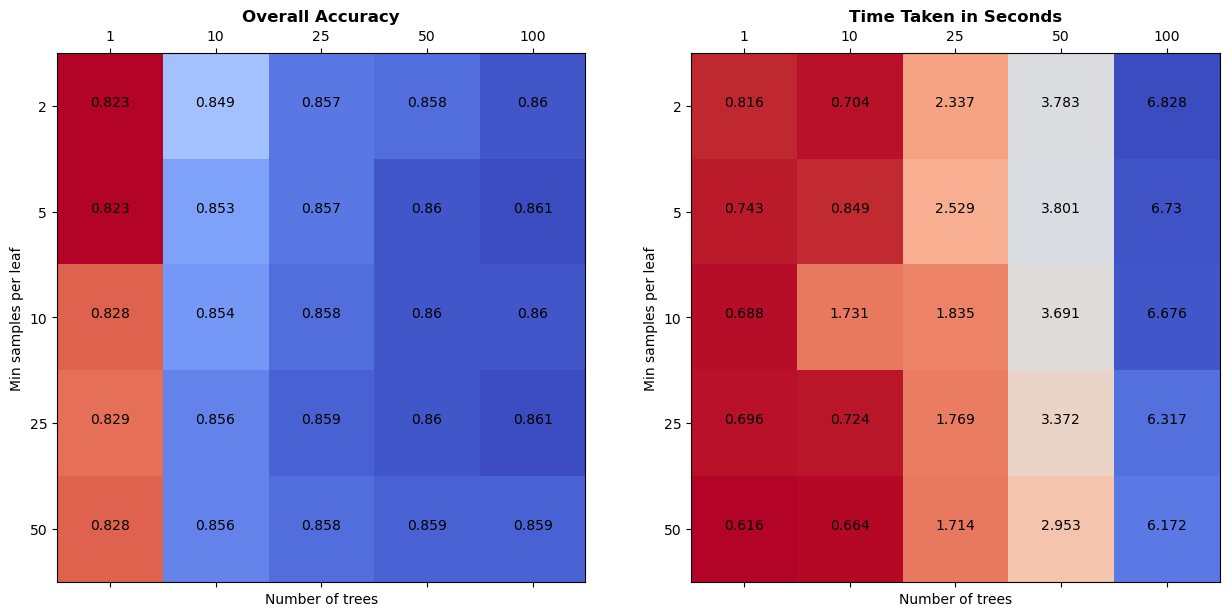

In [25]:
## Dirty work-around for first label not showing when plotting
n_trees_labels = [0] + n_trees_range
min_leaves_labels = [0] + min_samples_range 

fig, (ax_acc, ax_time) = plt.subplots(1, 2, figsize=(15,15))

## Plot accuracy
ax_acc.set_title("Overall Accuracy", weight='bold')
ax_acc.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_acc.set_xticklabels(n_trees_labels)
ax_acc.set_yticklabels(min_leaves_labels)
ax_acc.matshow(acc_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot time taken
ax_time.set_title("Time Taken in Seconds", weight='bold')
ax_time.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_time.set_xticklabels(n_trees_labels)
ax_time.set_yticklabels(min_leaves_labels)
ax_time.matshow(time_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Add text to accuracy plot
for t_i, t_val in enumerate(n_trees_range):
    for l_i, l_val in enumerate(min_samples_range):
        ax_acc.text(t_i, l_i, s=acc_paramsearch[t_i, l_i], ha='center')

## Add text to time plot
for t_i, t_val in enumerate(n_trees_range):
    for l_i, l_val in enumerate(min_samples_range):
        ax_time.text(t_i, l_i, s=time_paramsearch[t_i, l_i], ha='center')

#### **``Question 4a``**

``Looking at the left plot of the grid above, is the model accuracy for each parameter pair as you would expect it? Why/why not?``

**``Answer 4a``**

No. We would expect an increase in model accuracy with an increase of number of trees and a decrease of minimum samples per leaf node. However, we are getting better results when we include a limited number of trees (25) and allow a minimum number of 25 samples per leaf node.

#### **``Question 4b``**

``What about the time taken for each parameter? Is it according to your expectations? Why/why not?``

**``Answer 4b``**

In the case of the time, the general trend shows higher times with more complex models (More trees and smaller minimum samples per leaf). However there are some cases where this trend is not being followed, for instance when we increase frome 1 to 10 trees the times sometimes decrease.

#### **``Question 4c``**

``Given the above, which combination of parameters do you pick for the final model, and why do you pick that combination?``

**``Answer 4c``**

We would pick 25 trees and 25 minimum samples per leaf nodes, since this model performs as good as other complex models, but is simpler (probably performs better in the test dataset) and runs faster (1.76 s).

## 5. Model training

#### **``Action 5``**

``Finish the line which calls the random forest classifier with your chosen parameters and train the model.``

In [26]:
## Fill in your choice of parameters and set up the random forest classifier
num_trees = 25
min_num_leaves = 25

model = RandomForestClassifier(n_estimators=n_trees, min_samples_split=min_num_leaves, random_state=42)

## Run the classifier on the entire training set
train_start = datetime.now()
model.fit(train_pixels, train_labels)
train_end = datetime.now()
time_taken = float(f"{(train_end - train_start).seconds}.{round((train_end - train_start).microseconds, 2)}")

## Check training accuracy
train_preds = model.predict(train_pixels)
train_acc = accuracy_score(train_preds, train_labels)

## Run the model on the validation pixels
val_preds = model.predict(val_pixels)
val_acc = accuracy_score(val_preds, val_labels)

print(f'Training accuracy:   {train_acc:.4f}')
print(f'Validation accuracy: {val_acc:.4f}')
print(f'Training time:       {time_taken:.3f} seconds')

Training accuracy:   0.9666
Validation accuracy: 0.8624
Training time:       65.501 seconds


## **6. Feature Selection**

In [47]:
## The GINI coefficient is calculated by default when training a model
features_gini = model.feature_importances_

## We fit a second model to derive the entropy of each variable
entropy_model = RandomForestClassifier(n_estimators=num_trees,
                                       min_samples_split=min_num_leaves, 
                                       criterion='entropy',
                                       random_state=1)
entropy_model.fit(train_pixels, train_labels)
features_entropy = entropy_model.feature_importances_

In [153]:
importance_df.sort_values('entropy').iloc[:,1].reset_index(drop=True)

0     0.016546
1     0.042511
2     0.018007
3     0.038026
4     0.043822
5     0.034048
6     0.049507
7     0.047404
8     0.054148
9     0.053392
10    0.047501
11    0.052433
12     0.05735
13    0.075417
14    0.074446
15    0.099187
16    0.077296
17    0.118959
Name: gini, dtype: object

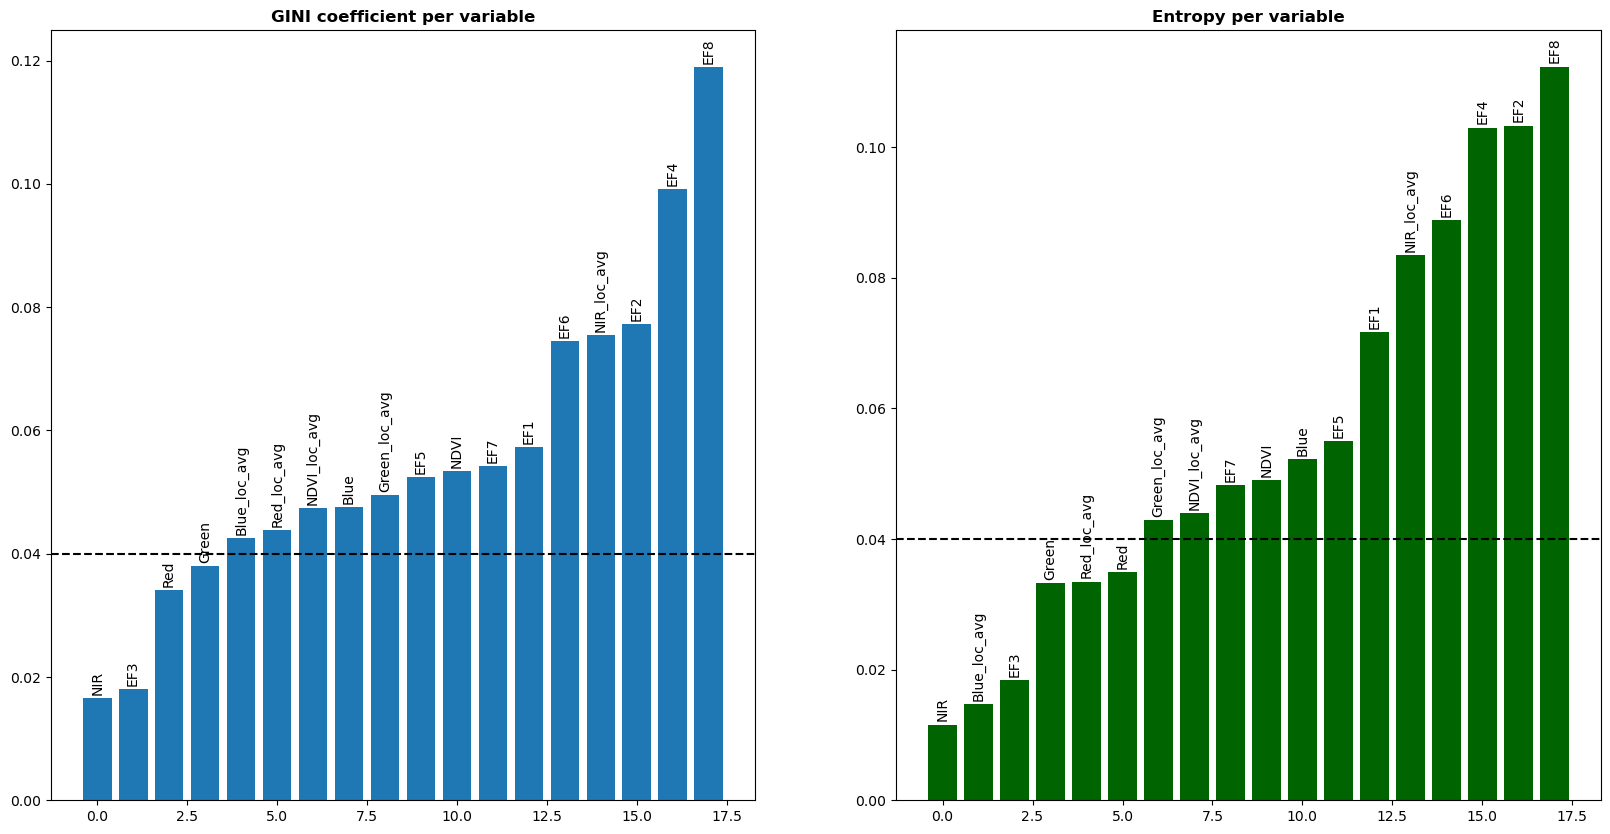

In [156]:
## Give each feature band a name
feature_names = [
                 'Red',
                 'Green',
                 'Blue',
                 'NIR',
                 'NDVI',
                 'NDVI_loc_avg',
                 'Red_loc_avg',
                 'Green_loc_avg',
                 'Blue_loc_avg',
                 'NIR_loc_avg',
                 'EF1',
                 'EF2',
                 'EF3',
                 'EF4',
                 'EF5',
                 'EF6',
                 'EF7',
                 'EF8'
]

importance_df = pd.DataFrame([feature_names, features_gini, features_entropy])
importance_df = importance_df.T
importance_df.columns = ['feature', 'gini', 'entropy']

## Make bar plots
x_axis = range(len(features_gini))
fig, (ax_gini, ax_entropy) = plt.subplots(1, 2, figsize=(20,10))
ax_gini.bar(x_axis, importance_df['gini'].sort_values())
ax_gini.set_title("GINI coefficient per variable", weight='bold')
ax_entropy.bar(x_axis, importance_df['entropy'].sort_values(), color='darkgreen')
ax_entropy.set_title("Entropy per variable", weight='bold')

## Add labels to the bars
for index, label in enumerate(importance_df.sort_values('gini').iloc[:,0].reset_index(drop=True)):
    ax_gini.text(index, y=importance_df.sort_values('gini').iloc[:,1].reset_index(drop=True)[index] + 0.001, s=label, ha='center', rotation=90)

for index, label in enumerate(importance_df.sort_values('entropy').iloc[:,0].reset_index(drop=True)):
    ax_entropy.text(index, y=importance_df.sort_values('entropy').iloc[:,2].reset_index(drop=True)[index]+0.001, s=label, ha='center', rotation=90)   

ax_gini.axhline(0.04, c = 'k', ls = '--')
ax_entropy.axhline(0.04, c = 'k', ls = '--')

array([0.01654597, 0.01800694, 0.03404756, 0.03802627, 0.04251078,
       0.04382181, 0.04740379, 0.04750123, 0.04950689, 0.05243343,
       0.05339229, 0.05414756, 0.05735006, 0.07444589, 0.07541705,
       0.0772961 , 0.09918746, 0.11895894])

#### **``Question 5a``**

``What is plotted in the bar plots above? What does each metric tell us about the variables? (Hint: check page 344 of the book)``

**``Answer 5a``**

In the bar plots we can see the impurity of a predictor. That represent the mean decrease in Gini and entropy respectively, relatively to the maximum decrease per variable. In that sense, variables with low importance could be removed without 

#### **``Question 5b``**

``Based on the plots above, which variables would you leave out of the model, and why would you leave them out?``

**``Answer 5b``**

| **Features to be removed**|
| ------------------------- |
| NIR_loc_avg |
| EF2 |
| EF4 |
| EF5 |
| EF7 |
| EF8 |

In [ ]:
import pandas as pd
import seaborn as sns

cor_mat = pd.DataFrame(train_pixels, columns = feature_names).corr()

sns.heatmap(cor_mat[np.abs(cor_mat) > 0.8], vmin = -1, vmax = 1, cmap = 'seismic')

The correlation matrix above shows that all EF variables have a high correlation between each other. this would lead to colinearity problems. Therefore, it would be recommended to remove some of these variables.

#### **``Action 6``**

``Determine which variables to remove in the final model by defining a list below``

In [ ]:
## Determine which variables to remove by using their band names
features_to_remove = ['NIR_loc_avg', 'EF2', 'EF4', 'EF5', 'EF7', 'EF8']

features_to_remove = [f.lower() for f in features_to_remove]
features_to_keep = [i for i, k in enumerate(feature_names) if not k.lower() in features_to_remove]

## Update all feature selections
selected_train_pixels = train_pixels[:, features_to_keep]
selected_val_pixels = val_pixels[:, features_to_keep]

#### **``Action 7``**

``Edit the line below to initialize the random forest model``

In [ ]:
## Initialize the final model that we will train
final_model = RandomForestClassifier(n_estimators=n_trees, min_samples_split=min_num_leaves)

## Train the model on the training dataset
selected_train_start = datetime.now()
final_model.fit(selected_train_pixels, train_labels)
selected_train_end = datetime.now()
selected_time_taken = float(f"{(selected_train_end - selected_train_start).seconds}.{round((selected_train_end - selected_train_start).microseconds, 2)}")

## Check the updated model's accuracy on the training set
selected_train_preds = final_model.predict(selected_train_pixels)
seleted_train_acc = accuracy_score(selected_train_preds, train_labels)

## Check the accuracy on the validation set
selected_val_preds = final_model.predict(selected_val_pixels)
selected_val_acc = accuracy_score(selected_val_preds, val_labels)

print(f'Training accuracy:   {seleted_train_acc:.4f}')
print(f'Validation accuracy: {selected_val_acc:.4f}')
print(f'Training time:       {selected_time_taken:.3f} seconds')

#### **``Question 6``**

``Most likely, the validation accuracy of your new model went down compared to the model using all of the variables. Why then is it still important to perform feature selection, even if it leads to slightly lower accuracy values?``

**``Answer 6``**

It is still important, because some features have high correlations between each other. Therefore, they might lead to multicolinearity problems (See correlation matrix above). Additionally, having too meany features might also overfit the model and therefore the performance in the test dataset will be worse. Finally, a model with more predictors would be more computationally expensive than a simpler model.

## **7. Inference**

#### **``Question 7``**

``Which part of the data will you use for this inference run?``

**``Answer 7``**

The test dataset

#### **``Action 8``**

``Fill in the variable name of the raster that you intend to use for testing``

In [ ]:
## Select the image to use during testing
test_raster = img2_normalized ## Hint: It should be normalized
test_raster = test_raster[features_to_keep,:, :]

## Model only supports 2-dim input, so we need to perform the model row-wise
## We make a matrix to store the prediction results in
test_results_matrix = np.ones_like(img2_gt)

## Apply the model on every row of the input image.
for xdim_index in range(img2_normalized.shape[1]):
    test_row = test_raster[:,xdim_index,:]
    test_row_preds = final_model.predict(test_row.transpose())
    test_results_matrix[:, xdim_index,:] = test_row_preds

## **8. Prediction Quality Control**

In [ ]:
## Make a color map for the predictions
values_in_preds = np.unique(test_results_matrix)
preds_class_map = class_cm[values_in_preds]
preds_cmap = ListedColormap(preds_class_map)

## Create plots for the images
fig, (ax_img2, ax_img2_gt, ax_img2_pred) = plt.subplots(1, 3, figsize=(20,20))
rio_plot.show(img2_fixed[:3], ax=ax_img2)
ax_img2.xaxis.set_ticks_position('top')
ax_img2.set_title("Image 2 in RGB")

ax_img2_gt.matshow(img2_gt[0], cmap=img2_cmap)
ax_img2_gt.set_title("Ground truth labels for image 2")

ax_img2_pred.matshow(test_results_matrix[0], cmap=preds_cmap)
ax_img2_pred.set_title("Predictions of the final model")
plt.show(fig)

#### **``Question 8a``**

``Are you satisfied with the prediction results? Why, or why not?``

**``Answer 8a``**

No. No significant difference is evident between grass and trees in our classified image. Additionally, there are multiple pixels in the city that are classified as water. 

#### **``Question 8b``**

``Do you see any systematic errors in the predictions? (random blunders, systematic confusions, etc)? Which ones and where?``

**``Answer 8b``**

Most grass classes are classified as trees and a lot of shadows are classified as water. Finally, most background pixels where classiffied as street or building.

#### **``Question 8c``**

``How do you think these can be avoided?``

**``Answer 8c``**

Using more meaningfull features related to the specific categories. For instance to split grass from trees we could use a textural feature since tree texture will probablly be different than grass. Also, height data could be usefull to split both trees from grassland and buildings from roads.

In [ ]:
## Set pixels in the prediction raster which have a 0 in the ground truth at the same index to 0
corrected_predictions = test_results_matrix.copy()
corrected_predictions[img2_gt == 0] = 0

## Update the color map
values_in_preds = np.unique(corrected_predictions)
preds_class_map = class_cm[values_in_preds]
preds_cmap = ListedColormap(preds_class_map)

## Plot the corrected label maps side by side
fig, (ax_img2_gt, ax_img2_pred) = plt.subplots(1, 2, figsize=(15,15))
ax_img2_gt.matshow(img2_gt[0], cmap=img2_cmap)
ax_img2_gt.set_title("Ground truth labels for image 2")

ax_img2_pred.matshow(corrected_predictions[0], cmap=preds_cmap)
ax_img2_pred.set_title("Corrected predictions of the final model")
plt.show(fig)

#### **``Question 9``**

``Based on the corrected pixel map above, make an educated guess on what the overall accuracy will be. Mention the number and briefly explain what it is based on.``

**``Answer 9``**

We guess that the overall accuracy could be between 60 % and 70 % since most of the water and tree pixels are properly classified and those categories represent high amount of the surface. Nevethless the categories road and buildings contains big errors, decreasing thus the overall accuracy.

In [ ]:
## Compute accuracy over the test set without considering the background class
gt_zeros_removed = img2_gt[img2_gt != 0]
preds_zeros_removed = test_results_matrix[img2_gt != 0]

test_acc = accuracy_score(preds_zeros_removed.ravel(), gt_zeros_removed.ravel())
print(f'Test overall accuracy:   {test_acc:.4f}')

#### **``Question 10a``**

``Are you surprised by the overall accuracy? Why/why not?``

**``Answer 10a``**

We tought it was between 60 and 70 % so we are not surprised. We thought the algorithm perform better than random guess but still not that good.

#### **``Question 10b``**

``Do you think that the achieved overall accuracy reflects the quality of the final model? (Again, take into account that white background pixels have been manually set in the plot above)``

**``Answer 10b``**

Not completely, the overall accuracy gives and indication of how well the model performs in general, but does not show how well it is classifying each category and which categories are splitted better than others.

In [ ]:
## Get matrix labels from the predictions in the ground truth raster
labels = [k for i, k in enumerate(class_colors_dict) if i in set(gt_zeros_removed)]

## Make confusion matrix
conf_matrix = confusion_matrix(gt_zeros_removed.ravel(), preds_zeros_removed.ravel())
conf_matrix_viewer = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
conf_matrix_viewer.plot(cmap=plt.get_cmap('binary'))

#### **``Question 11``**

``Which classes are confused with one another most often? Can you reason why these classes are confused most often?``

**``Answer 11``**

The pairs of classes (roads and buildings) and (trees and grass) are the ones that are confused most frequently. This happens, because they have very similar characteristics in the spectral space that we are using to predict. 

#### **``Question 12``**

``In your own words, describe what the precision and recall scores represent, and how they're calculated. You can use internet resources or literature to help explain these concepts.``

**``Answer 12``**

The **precision** is the proportion of the correctly classified values for a class over the complete set of predicted values for that specific class.

$$ Prcision = \frac{TP}{TP + FP} $$

The **recall** is the proportion of the correctly classified values for a class over the complete set of true values for that specific class.

$$ Recall = \frac{TP}{TP + FN} $$


In [ ]:
## Calculate precision and recall scores for each class individually
test_precisions = precision_score(preds_zeros_removed.ravel(), gt_zeros_removed.ravel(), average=None)
test_recalls = recall_score(preds_zeros_removed.ravel(), gt_zeros_removed.ravel(), average=None)

## Print these for each class separately
print("Test set precision scores per class")
for i, label in enumerate(labels):
    print(f"{label}: {test_precisions[i]:.4f}")
print("\n")
print("Test set recall scores per class")
for i, label in enumerate(labels):
    print(f"{label}: {test_recalls[i]:.4f}") 

#### **``Question 13a``**

``When you compare these precision/recall scores with the overall accuracy, how has your perception of the performance of the model changed?``

**``Answer 13a``**

Now, it is evident that the model predicts the category water well, but doesn't perform that good when classifying the other categories. Moreover, it can be seen numerically which categories have some issues with false positives or false negatives. For instance, grass has a big number of pixels that were misclassified as grass compared to the number of pixels that were correctly classified as grass. Hence, the precision is really low.

#### **``Question 13b``**

``Now that you've seen all of the statistical results, which label predictions do you think are primarily responsible for the high overall accuracy?``

**``Answer 13b``**

The water and tree classes.